# Predicting the Severity of LBP

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost
from xgboost import XGBClassifier


## 1. Data Wrangling

In [2]:
#Load data
df=pd.read_csv('/Users/nirathikeerthi/Desktop/Springboard/Capstone 3 - LBP/LBP_data.csv')

In [3]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant No.        60 non-null     int64  
 1   Gender                 60 non-null     object 
 2   Age                    60 non-null     int64  
 3   Height                 60 non-null     int64  
 4   Weight                 60 non-null     int64  
 5   BMI                    60 non-null     float64
 6   Ethnicity              60 non-null     object 
 7   History                60 non-null     object 
 8   Physical_activity      60 non-null     int64  
 9   Alcohol                60 non-null     int64  
 10  Smoking                60 non-null     int64  
 11  Hours/day              60 non-null     object 
 12  Years                  54 non-null     float64
 13  Occ_Score              60 non-null     int64  
 14  Posture                60 non-null     int64  
 15  Force   

In [4]:
df.drop(columns='Participant No.', inplace=True)

In [5]:
# No. of rows and columns
df.shape

(60, 28)

In [6]:
#visualize
df.head()

,Gender,Age,Height,Weight,BMI,Ethnicity,History,Physical_activity,Alcohol,Smoking,...,JCQ_Score,Decision_Latitude,Physical_Demands,Psychological_Demands,Social_Support,Organizational_Level,Job_Satisfaction,Job_Security,ODI_Score,VAS
0,F,37,62,162,29.626951,Caucasian,Yes,1,1,1,...,162.000000,78,5,8,38,34,0.000000,-1,30,10.00
1,M,72,64,184,31.580078,Caucasian,Yes,4,2,3,...,183.100000,70,10,8,31,61,0.100000,3,70,10.00
2,F,56,65,168,27.953609,Caucasian,No,1,2,3,...,152.566667,66,16,6,33,30,0.566667,1,94,9.84
3,F,60,65,218,36.273136,Black,No,6,3,4,...,172.566667,72,19,16,30,29,0.566667,6,44,8.27
4,M,38,72,209,28.342400,Caucasian,No,1,3,1,...,145.000000,74,10,2,30,28,0.000000,1,40,7.01


In [7]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    6
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         1
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [8]:
#Checking for missing values
df.isin(['?']).sum(axis=0)

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

In [9]:
# Calculate average ODI and VAS by History and sort by the average of the two
history_means = df.groupby('History')[['ODI_Score', 'VAS']].mean()
history_means.head()

,ODI_Score,VAS
History,,
No,38.750000,8.095417
Yes,43.222222,7.738333


In [10]:
# Calculate average ODI and VAS by Gender and sort by the average of the two
gender_means = df.groupby('Gender')[['ODI_Score', 'VAS']].mean()
gender_means.head()

,ODI_Score,VAS
Gender,,
F,41.352941,7.929706
M,41.538462,7.817692


In [11]:
# Calculate average ODI and VAS by Ethnicity and sort by the average of the two
ethnicity_means = df.groupby('Ethnicity')[['ODI_Score', 'VAS']].mean()
ethnicity_means.head()

,ODI_Score,VAS
Ethnicity,,
Black,43.444444,7.134444
Caucasian,41.641026,8.157179
Other,26.666667,8.773333


In [12]:
df['Ethnicity'].value_counts()

Caucasian    39
Black        18
Other         3
Name: Ethnicity, dtype: int64

In [13]:
# Calculate average ODI and VAS by Hours/day and sort by the average of the two
hours_means = df.groupby('Hours/day')[['ODI_Score', 'VAS']].mean()
hours_means.head()

,ODI_Score,VAS
Hours/day,,
10,42.363636,8.528182
11,16.000000,8.280000
12,42.857143,8.228571
16,56.000000,4.170000
2,48.000000,8.130000


In [14]:
df['Hours/day'].value_counts()

8      22
10     11
12      7
6       4
9       4
5       4
4       2
2       1
7       1
11      1
>8      1
16      1
>8      1
Name: Hours/day, dtype: int64

In [15]:
df.replace('>8 ','99',inplace=True)

In [16]:
df['Hours/day'].value_counts()

8     22
10    11
12     7
6      4
9      4
5      4
4      2
2      1
7      1
99     1
11     1
>8     1
16     1
Name: Hours/day, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 60 non-null     object 
 1   Age                    60 non-null     int64  
 2   Height                 60 non-null     int64  
 3   Weight                 60 non-null     int64  
 4   BMI                    60 non-null     float64
 5   Ethnicity              60 non-null     object 
 6   History                60 non-null     object 
 7   Physical_activity      60 non-null     int64  
 8   Alcohol                60 non-null     int64  
 9   Smoking                60 non-null     int64  
 10  Hours/day              60 non-null     object 
 11  Years                  54 non-null     float64
 12  Occ_Score              60 non-null     int64  
 13  Posture                60 non-null     int64  
 14  Force                  60 non-null     int64  
 15  Repetiti

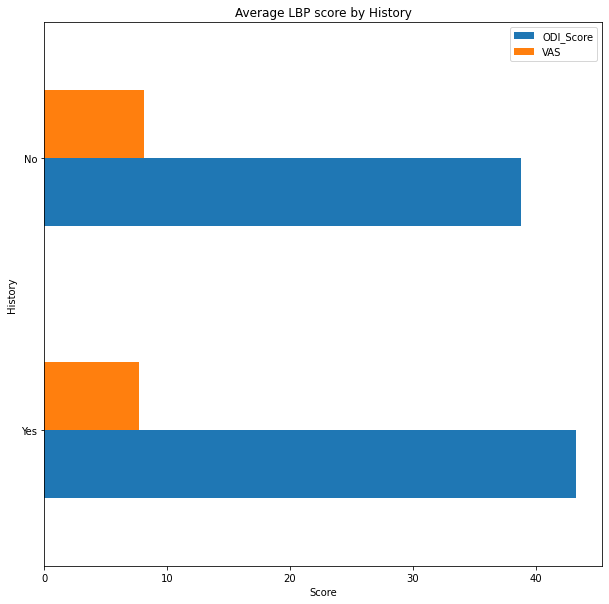

In [18]:
(history_means.reindex(index=history_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Average LBP score by History'))
plt.xlabel('Score');

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,60.0,47.083333,16.172053,20.000000,33.000000,48.000000,57.25000,83.000000
Height,60.0,67.033333,3.875025,59.000000,64.000000,66.000000,70.00000,75.000000
Weight,60.0,184.533333,37.726252,95.000000,160.000000,180.000000,211.25000,275.000000
BMI,60.0,28.859479,5.348535,16.826657,25.807846,28.233276,31.65558,42.126754
Physical_activity,60.0,2.533333,1.599435,1.000000,1.000000,3.000000,4.00000,6.000000
Alcohol,60.0,1.750000,0.772954,1.000000,1.000000,2.000000,2.00000,3.000000
Smoking,60.0,1.600000,1.028410,1.000000,1.000000,1.000000,2.00000,5.000000
Years,54.0,12.722222,10.901647,1.000000,4.000000,10.000000,20.00000,50.000000
Occ_Score,60.0,12.283333,6.279079,3.000000,6.000000,12.000000,17.25000,27.000000
Posture,60.0,6.300000,1.985541,3.000000,5.000000,6.000000,8.00000,10.000000


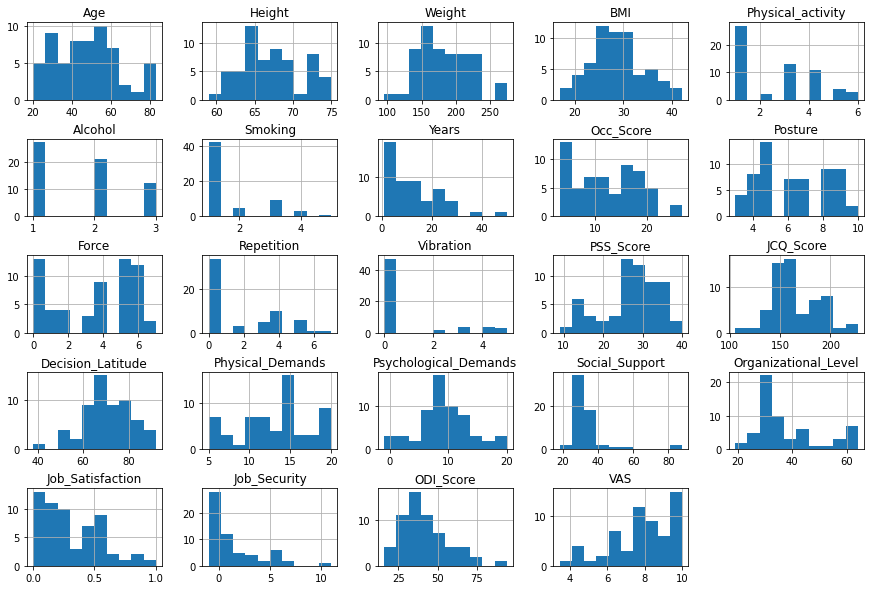

In [20]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [21]:
df['Years'].value_counts()

1.0     5
2.0     5
10.0    4
4.0     4
3.0     3
22.0    3
15.0    3
30.0    3
20.0    3
11.0    2
25.0    2
13.0    2
5.0     2
12.0    2
7.0     2
9.0     1
21.0    1
26.0    1
40.0    1
24.0    1
16.0    1
6.0     1
50.0    1
8.0     1
Name: Years, dtype: int64

In [22]:
df=df.fillna(df.median())

In [23]:
#Checking for null values
df.isnull().sum()

Gender                   0
Age                      0
Height                   0
Weight                   0
BMI                      0
Ethnicity                0
History                  0
Physical_activity        0
Alcohol                  0
Smoking                  0
Hours/day                0
Years                    0
Occ_Score                0
Posture                  0
Force                    0
Repetition               0
Vibration                0
PSS_Score                0
JCQ_Score                0
Decision_Latitude        0
Physical_Demands         0
Psychological_Demands    0
Social_Support           0
Organizational_Level     0
Job_Satisfaction         0
Job_Security             0
ODI_Score                0
VAS                      0
dtype: int64

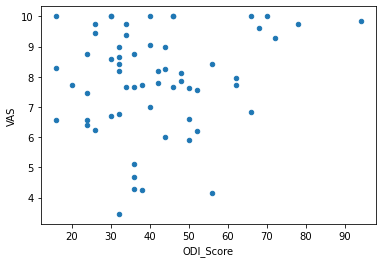

In [24]:
# Target Feature
df.plot(x='ODI_Score', y='VAS', kind='scatter');

In [25]:
df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [26]:
df['VAS'].value_counts()

10.00    8
9.76     3
7.66     3
6.56     2
7.72     2
8.43     2
4.17     1
7.48     1
7.56     1
9.45     1
6.61     1
8.67     1
5.12     1
6.25     1
9.29     1
6.85     1
7.64     1
4.69     1
7.01     1
7.97     1
8.75     1
7.79     1
4.30     1
8.98     1
9.00     1
6.69     1
6.02     1
3.46     1
6.77     1
9.06     1
7.73     1
8.19     1
6.22     1
8.13     1
8.28     1
8.74     1
8.59     1
8.20     1
5.91     1
9.61     1
4.25     1
8.27     1
7.87     1
9.37     1
6.41     1
9.84     1
Name: VAS, dtype: int64

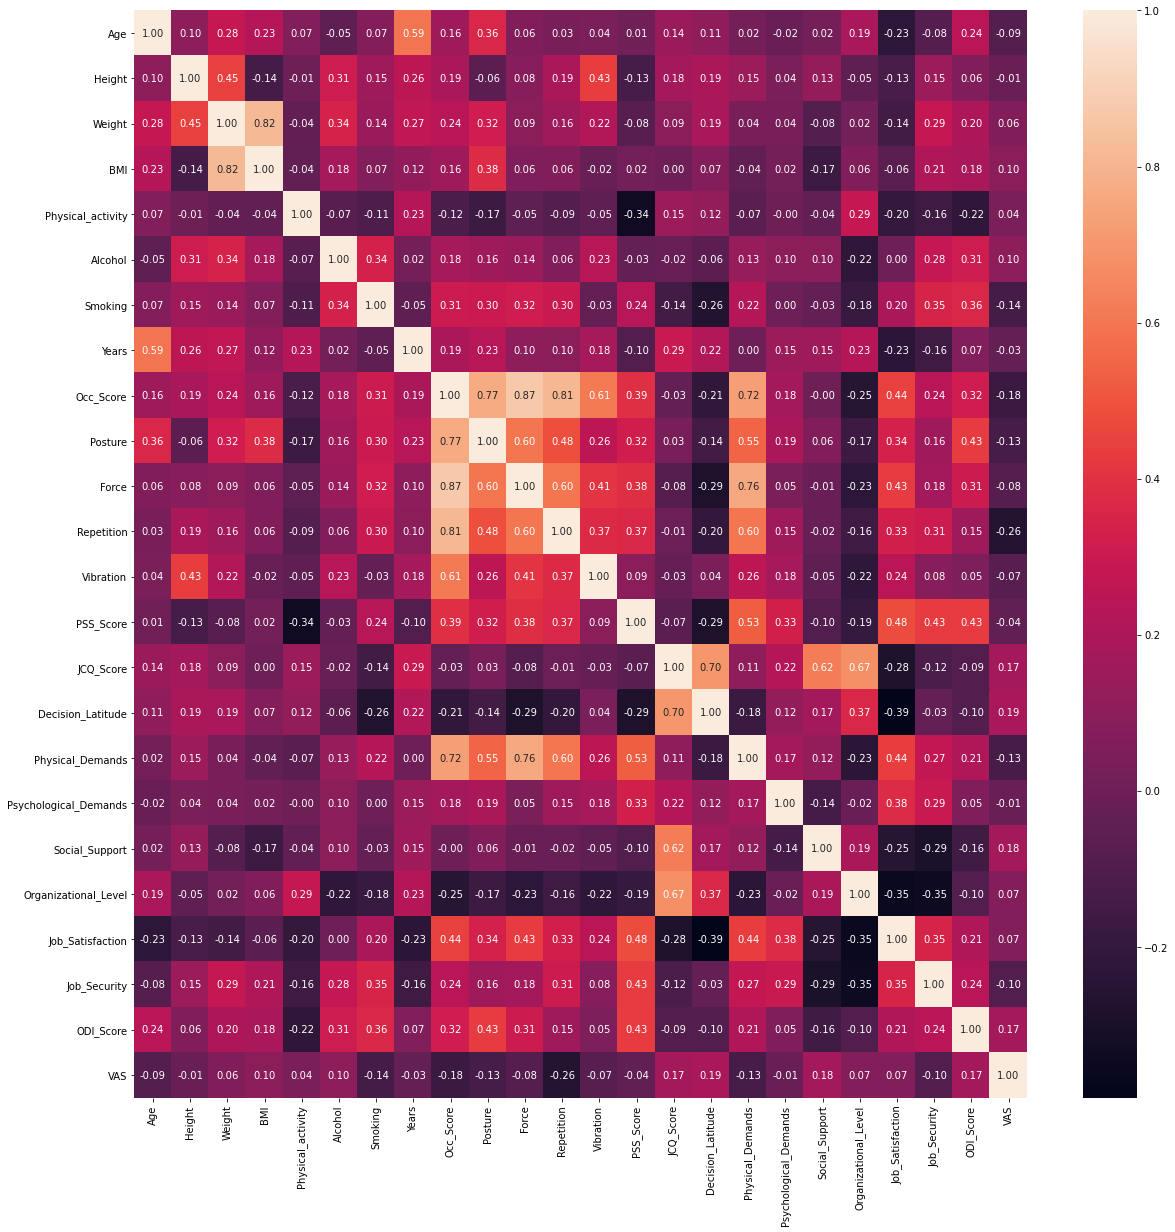

In [27]:
#Visualize correlation of the target variable with other features
plt.subplots(figsize=(20,20))

corr = df.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

## 2. EDA

In [28]:
#Scatter Plots
# define useful function to create scatterplots against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ODI_Score', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='ODI_Score')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [29]:
features = [column for column in df.columns if column not in ['Gender', 'History', 'Ethnicity', 'VAS', 'ODI_Score']]

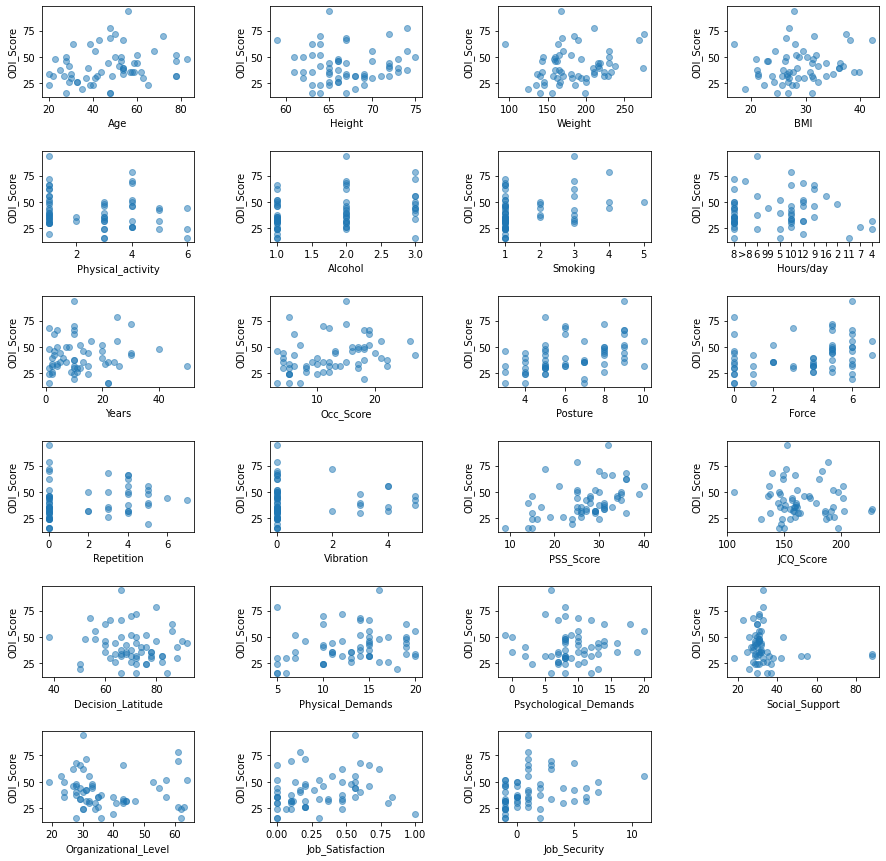

In [30]:
scatterplots(features, ncol=4, figsize=(15, 15))

In [33]:
#Create dataframe with only occupational factors
occ_df = df[['Posture', 'Force', 'Repetition', 'Vibration', 'ODI_Score']]

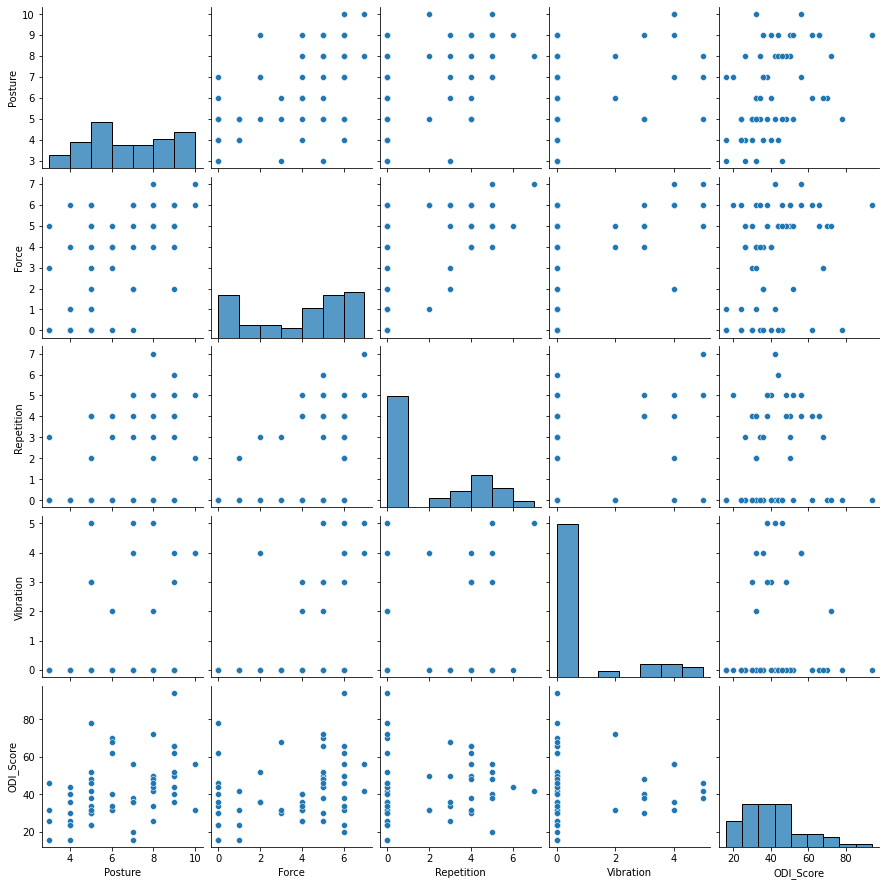

In [34]:
# Make a pairplot of the data
sns.pairplot(occ_df)

## 3. Preprocessing & Feature Selection

In [35]:
occ_df['Posture'].value_counts()

5     14
8      9
9      9
4      8
6      7
7      7
3      4
10     2
Name: Posture, dtype: int64

In [36]:
bins = [0, 5, 10]
labels = ['neutral', 'nonneutral']
occ_df['Posture_cat'] = pd.cut(occ_df['Posture'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
occ_df['Posture_cat'].value_counts()

nonneutral    34
neutral       26
Name: Posture_cat, dtype: int64

In [38]:
occ_df['Force'].value_counts()

0    13
5    13
6    12
4     9
1     4
2     4
3     3
7     2
Name: Force, dtype: int64

In [39]:
bins = [-np.inf, 4, 7]
labels = ['low', 'high']
occ_df['Force_cat'] = pd.cut(occ_df['Force'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
occ_df['Force_cat'].value_counts()

low     33
high    27
Name: Force_cat, dtype: int64

In [41]:
occ_df['Repetition'].value_counts()

0    34
4    10
5     6
3     5
2     3
6     1
7     1
Name: Repetition, dtype: int64

In [42]:
bins = [-np.inf, 1, 7]
labels = ['No', 'Yes']
occ_df['Rep_cat'] = pd.cut(occ_df['Repetition'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
occ_df['Rep_cat'].value_counts()

No     34
Yes    26
Name: Rep_cat, dtype: int64

In [44]:
occ_df['Vibration'].value_counts()

0    47
3     4
4     4
5     3
2     2
Name: Vibration, dtype: int64

In [45]:
bins = [-np.inf, 1, 5]
labels = ['No', 'Yes']
occ_df['Vib_cat'] = pd.cut(occ_df['Vibration'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
occ_df['Vib_cat'].value_counts()

No     47
Yes    13
Name: Vib_cat, dtype: int64

In [49]:
occ_df['ODI_Score'].value_counts()

32    6
36    5
24    4
30    4
34    3
40    3
50    3
16    3
46    3
26    3
44    3
56    2
52    2
48    2
42    2
66    2
38    2
62    2
68    1
94    1
20    1
78    1
72    1
70    1
Name: ODI_Score, dtype: int64

In [50]:
bins = [0, 20, 60, np.inf]
labels = ['0', '1', '2']
occ_df['ODI'] = pd.cut(occ_df['ODI_Score'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
bins = [0, 40, np.inf]
labels = ['0', '1']
occ_df['ODI2'] = pd.cut(occ_df['ODI_Score'], bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
occ_df['ODI'].value_counts()

1    47
2     9
0     4
Name: ODI, dtype: int64

In [53]:
occ_df['ODI2'].value_counts()

0    34
1    26
Name: ODI2, dtype: int64

In [54]:
occ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Posture      60 non-null     int64   
 1   Force        60 non-null     int64   
 2   Repetition   60 non-null     int64   
 3   Vibration    60 non-null     int64   
 4   ODI_Score    60 non-null     int64   
 5   Posture_cat  60 non-null     category
 6   Force_cat    60 non-null     category
 7   Rep_cat      60 non-null     category
 8   Vib_cat      60 non-null     category
 9   ODI          60 non-null     category
 10  ODI2         60 non-null     category
dtypes: category(6), int64(5)
memory usage: 3.6 KB


In [55]:
occ_df['ODI'] = occ_df['ODI'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
occ_df['ODI2'] = occ_df['ODI2'].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
occ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Posture      60 non-null     int64   
 1   Force        60 non-null     int64   
 2   Repetition   60 non-null     int64   
 3   Vibration    60 non-null     int64   
 4   ODI_Score    60 non-null     int64   
 5   Posture_cat  60 non-null     category
 6   Force_cat    60 non-null     category
 7   Rep_cat      60 non-null     category
 8   Vib_cat      60 non-null     category
 9   ODI          60 non-null     int64   
 10  ODI2         60 non-null     int64   
dtypes: category(4), int64(7)
memory usage: 4.1 KB


In [59]:
#Drop features
columns_to_drop=['ODI_Score', 'Posture', 'ODI2', 'Force', 'Repetition', 'Vibration']
dff=occ_df.drop(columns=columns_to_drop)

columns_to_drop2=['ODI_Score', 'Posture', 'ODI', 'Force', 'Repetition', 'Vibration']
dff2=occ_df.drop(columns=columns_to_drop2)

In [60]:
dff.shape

(60, 5)

In [61]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Posture_cat  60 non-null     category
 1   Force_cat    60 non-null     category
 2   Rep_cat      60 non-null     category
 3   Vib_cat      60 non-null     category
 4   ODI          60 non-null     int64   
dtypes: category(4), int64(1)
memory usage: 1.3 KB


In [62]:
dff2.shape

(60, 5)

In [63]:
dff2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Posture_cat  60 non-null     category
 1   Force_cat    60 non-null     category
 2   Rep_cat      60 non-null     category
 3   Vib_cat      60 non-null     category
 4   ODI2         60 non-null     int64   
dtypes: category(4), int64(1)
memory usage: 1.3 KB


In [64]:
#one hot encoding
df_encoded =pd.get_dummies(dff, columns=['Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat'])
df_encoded2 =pd.get_dummies(dff2, columns=['Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat'])

In [65]:
df_encoded.columns

Index(['ODI', 'Posture_cat_neutral', 'Posture_cat_nonneutral', 'Force_cat_low',
       'Force_cat_high', 'Rep_cat_No', 'Rep_cat_Yes', 'Vib_cat_No',
       'Vib_cat_Yes'],
      dtype='object')

In [66]:
df_encoded2.columns

Index(['ODI2', 'Posture_cat_neutral', 'Posture_cat_nonneutral',
       'Force_cat_low', 'Force_cat_high', 'Rep_cat_No', 'Rep_cat_Yes',
       'Vib_cat_No', 'Vib_cat_Yes'],
      dtype='object')

In [67]:
#Drop variables
names_list2 = ['Posture_cat_nonneutral', 'Force_cat_low', 'Rep_cat_No', 'Vib_cat_No']
df_encoded_fin=df_encoded.drop(columns=names_list2)
df_encoded_fin2=df_encoded2.drop(columns=names_list2)

In [68]:
df_encoded_fin.shape

(60, 5)

In [69]:
df_encoded_fin2.shape

(60, 5)

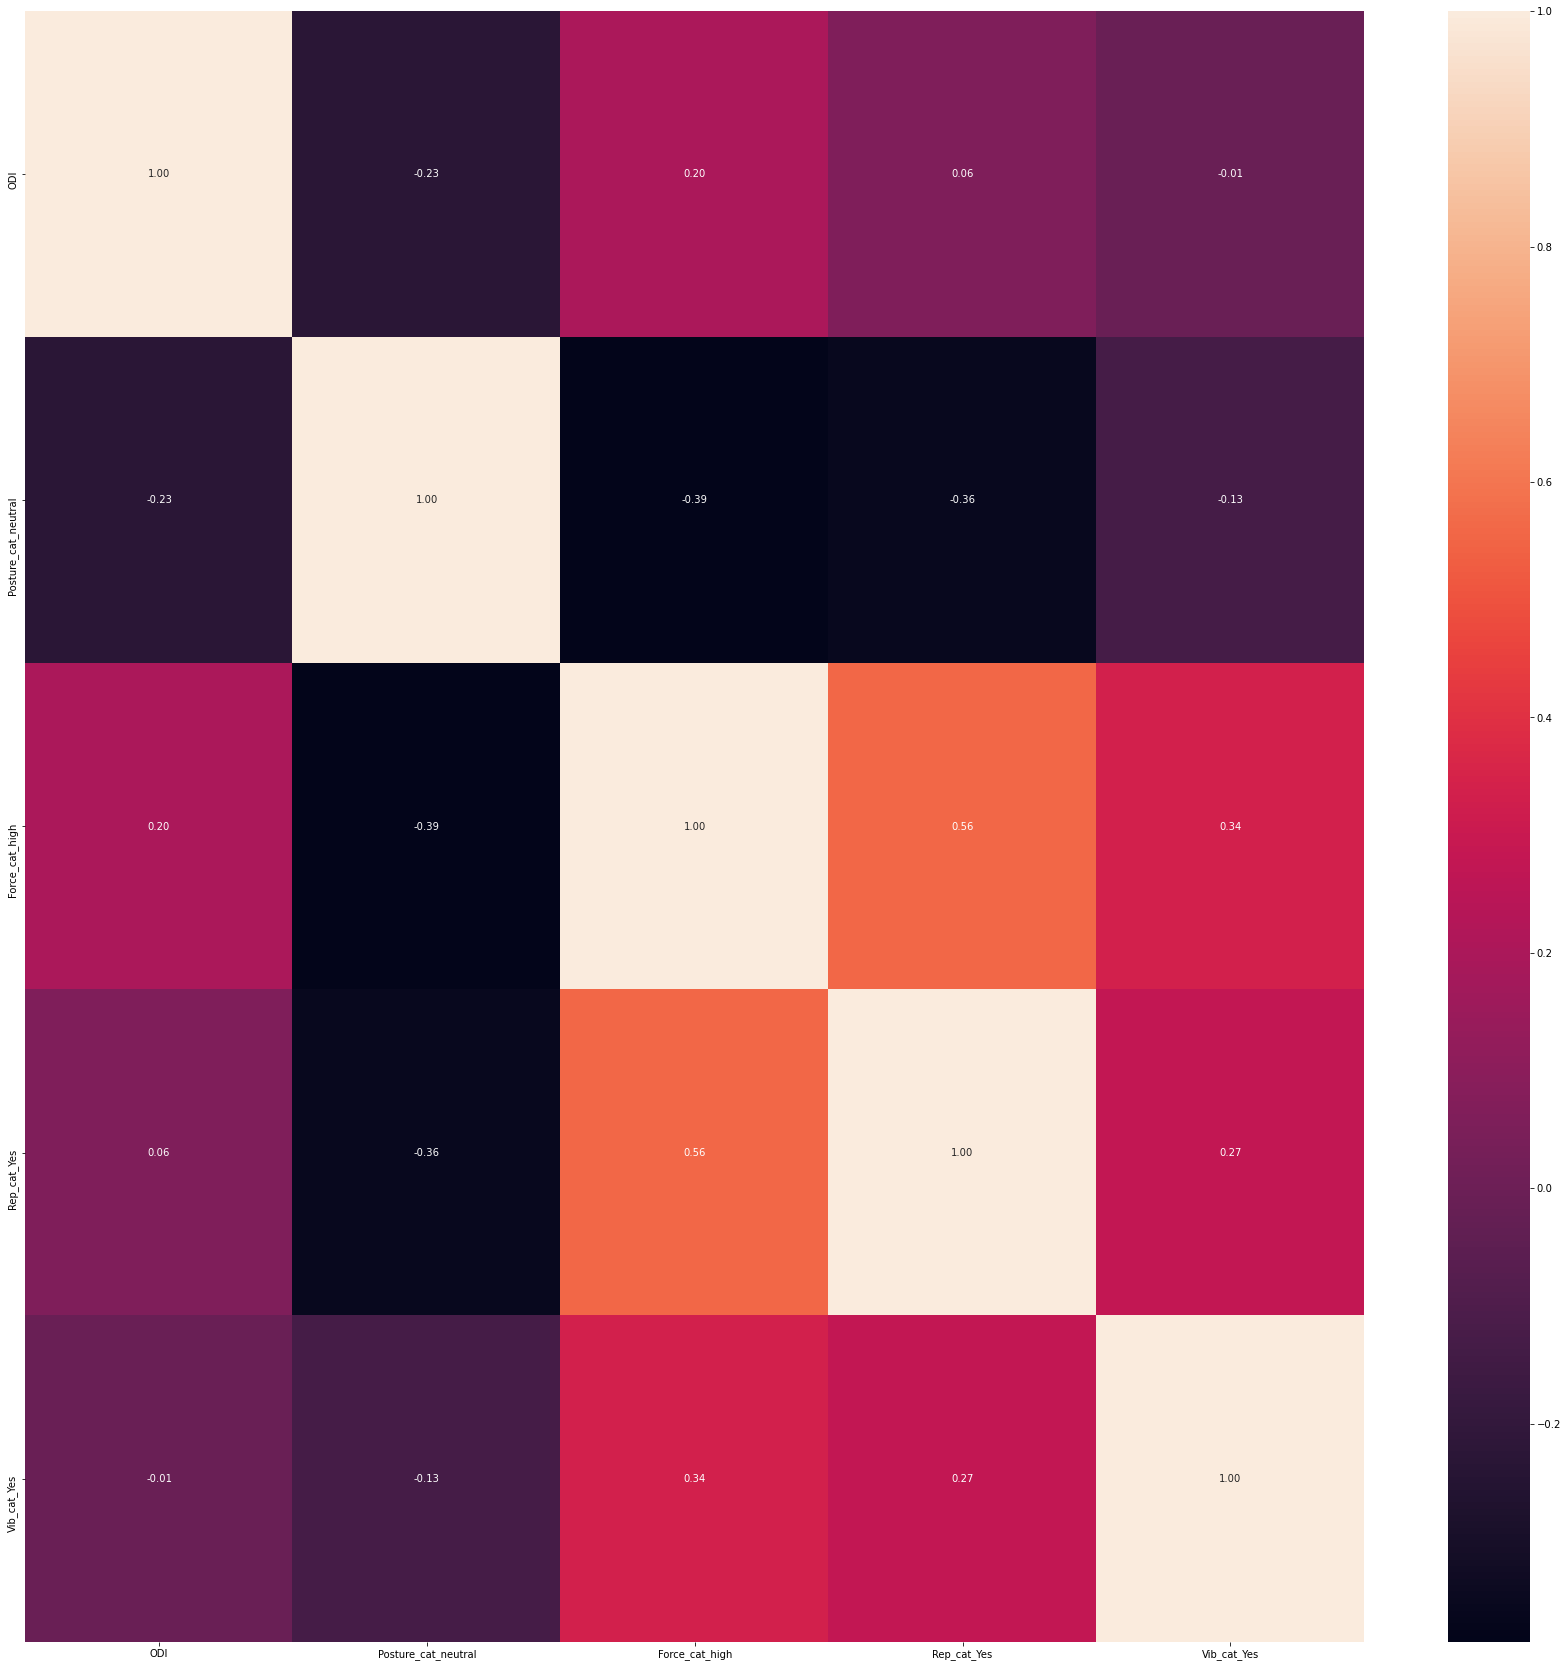

In [71]:
#Visualize correlation of target with other feathures
plt.subplots(figsize=(30,30))

corr = df_encoded_fin.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

### Tertiary Classification

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded_fin.drop(columns='ODI'), 
                                                    df_encoded_fin.ODI, test_size=0.3, 
                                                    random_state=47)

In [73]:
#Training
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

1    33
2     6
0     3
Name: ODI, dtype: int64
1    0.785714
2    0.142857
0    0.071429
Name: ODI, dtype: float64


In [74]:
#Test
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

1    14
2     3
0     1
Name: ODI, dtype: int64
1    0.777778
2    0.166667
0    0.055556
Name: ODI, dtype: float64


In [75]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model = clf.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest: Accuracy=0.667
Random Forest: f1-score=0.622


In [76]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [77]:
final_iv, IV = data_vars(X_train, y_train)

Posture_cat_neutral
Force_cat_high
Rep_cat_Yes
Vib_cat_Yes


invalid value encountered in log


In [78]:
X_train.head()

,Posture_cat_neutral,Force_cat_high,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1,1
10,0,0,0,0
11,0,1,1,0
19,0,1,1,1
21,1,1,1,1


In [79]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Posture_cat_neutral,0,0,23,26,1.130435,-3,-0.130435,0.577778,1.000000,-0.548566,0.231617
1,Posture_cat_neutral,1,1,19,19,1.000000,0,0.000000,0.422222,-0.000000,NaN,0.231617
2,Force_cat_high,0,0,26,27,1.038462,-1,-0.038462,0.600000,0.333333,0.587787,0.292963
3,Force_cat_high,1,1,16,18,1.125000,-2,-0.125000,0.400000,0.666667,-0.510826,0.292963
4,Rep_cat_Yes,0,0,27,30,1.111111,-3,-0.111111,0.666667,1.000000,-0.405465,0.135155
5,Rep_cat_Yes,1,1,15,15,1.000000,0,0.000000,0.333333,-0.000000,NaN,0.135155
6,Vib_cat_Yes,0,0,34,36,1.058824,-2,-0.058824,0.800000,0.666667,0.182322,0.092420
7,Vib_cat_Yes,1,1,8,9,1.125000,-1,-0.125000,0.200000,0.333333,-0.510826,0.092420


In [80]:
IV

,VAR_NAME,IV
0,Force_cat_high,0.292963
1,Posture_cat_neutral,0.231617
2,Rep_cat_Yes,0.135155
3,Vib_cat_Yes,0.092420


In [81]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(42, 4)

,Force_cat_high,Posture_cat_neutral,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1,1
10,0,0,0,0
11,1,0,1,0
19,1,0,1,1
21,1,1,1,1


In [82]:
display(X2.shape[1])
for i in range(X2.shape[1]):
    print((i, variance_inflation_factor(X2.values, i) ))

4

(0, 2.108565659703347)
(1, 1.0726877378271338)
(2, 2.214413295022133)
(3, 1.3176982216354742)


In [83]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Complete


In [84]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

4

Index(['Force_cat_high', 'Posture_cat_neutral', 'Rep_cat_Yes', 'Vib_cat_Yes'], dtype='object')

,Force_cat_high,Posture_cat_neutral,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1,1
10,0,0,0,0
11,1,0,1,0
19,1,0,1,1
21,1,1,1,1


### Binary Classification

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded_fin2.drop(columns='ODI2'), 
                                                    df_encoded_fin2.ODI2, test_size=0.3, 
                                                    random_state=47)

In [143]:
#Training
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    25
1    17
Name: ODI2, dtype: int64
0    0.595238
1    0.404762
Name: ODI2, dtype: float64


In [144]:
#Test
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    9
1    9
Name: ODI2, dtype: int64
0    0.5
1    0.5
Name: ODI2, dtype: float64


In [145]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model = clf.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest: Accuracy=0.556
Random Forest: f1-score=0.550


In [146]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [147]:
final_iv, IV = data_vars(X_train, y_train)

Posture_cat_neutral
Force_cat_high
Rep_cat_Yes
Vib_cat_Yes


In [148]:
X_train.head()

,Posture_cat_neutral,Force_cat_high,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1,1
10,0,0,0,0
11,0,1,1,0
19,0,1,1,1
21,1,1,1,1


In [149]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Posture_cat_neutral,0,0,23,13,0.565217,10,0.434783,0.764706,0.40,0.648027,0.577738
1,Posture_cat_neutral,1,1,19,4,0.210526,15,0.789474,0.235294,0.60,-0.936093,0.577738
2,Force_cat_high,0,0,26,6,0.230769,20,0.769231,0.352941,0.80,-0.818310,0.890733
3,Force_cat_high,1,1,16,11,0.687500,5,0.312500,0.647059,0.20,1.174120,0.890733
4,Rep_cat_Yes,0,0,27,10,0.370370,17,0.629630,0.588235,0.68,-0.144966,0.036439
5,Rep_cat_Yes,1,1,15,7,0.466667,8,0.533333,0.411765,0.32,0.252131,0.036439
6,Vib_cat_Yes,0,0,34,15,0.441176,19,0.558824,0.882353,0.76,0.149274,0.105496
7,Vib_cat_Yes,1,1,8,2,0.250000,6,0.750000,0.117647,0.24,-0.712950,0.105496


In [150]:
IV

,VAR_NAME,IV
0,Force_cat_high,0.890733
1,Posture_cat_neutral,0.577738
2,Rep_cat_Yes,0.036439
3,Vib_cat_Yes,0.105496


In [151]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(42, 3)

,Posture_cat_neutral,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1
10,0,0,0
11,0,1,0
19,0,1,1
21,1,1,1


In [152]:
display(X2.shape[1])
for i in range(X2.shape[1]):
    print((i, variance_inflation_factor(X2.values, i) ))

3

(0, 1.0636417206835593)
(1, 1.308190925162051)
(2, 1.2681202121390691)


In [153]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Complete


In [154]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

3

Index(['Posture_cat_neutral', 'Rep_cat_Yes', 'Vib_cat_Yes'], dtype='object')

,Posture_cat_neutral,Rep_cat_Yes,Vib_cat_Yes
27,1,1,1
10,0,0,0
11,0,1,0
19,0,1,1
21,1,1,1


### Regression

In [86]:
#Drop irrelevant variables
names_list = ['ODI', 'ODI2', 'Posture', 'Force', 'Repetition', 'Vibration']
dff3=occ_df.drop(columns=names_list)

In [87]:
#one hot encoding
df_encoded3 =pd.get_dummies(dff3, columns=['Posture_cat', 'Force_cat', 'Rep_cat', 'Vib_cat'])

In [88]:
df_encoded3.shape

(60, 9)

In [89]:
df_encoded3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   ODI_Score               60 non-null     int64
 1   Posture_cat_neutral     60 non-null     uint8
 2   Posture_cat_nonneutral  60 non-null     uint8
 3   Force_cat_low           60 non-null     uint8
 4   Force_cat_high          60 non-null     uint8
 5   Rep_cat_No              60 non-null     uint8
 6   Rep_cat_Yes             60 non-null     uint8
 7   Vib_cat_No              60 non-null     uint8
 8   Vib_cat_Yes             60 non-null     uint8
dtypes: int64(1), uint8(8)
memory usage: 1.1 KB


In [90]:
#Drop variables
names_list2 = ['Posture_cat_nonneutral', 'Force_cat_low', 'Rep_cat_No', 'Vib_cat_No']
df_encoded_fin3=df_encoded3.drop(columns=names_list2)

In [91]:
df_encoded_fin3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ODI_Score            60 non-null     int64
 1   Posture_cat_neutral  60 non-null     uint8
 2   Force_cat_high       60 non-null     uint8
 3   Rep_cat_Yes          60 non-null     uint8
 4   Vib_cat_Yes          60 non-null     uint8
dtypes: int64(1), uint8(4)
memory usage: 848.0 bytes


In [92]:
df_encoded_fin3['postxforce']=df_encoded_fin3.Posture_cat_neutral*df_encoded_fin3.Force_cat_high
df_encoded_fin3['postxrep']=df_encoded_fin3.Posture_cat_neutral*df_encoded_fin3.Rep_cat_Yes
df_encoded_fin3['postxvib']=df_encoded_fin3.Posture_cat_neutral*df_encoded_fin3.Vib_cat_Yes 
df_encoded_fin3['forcexrep']=df_encoded_fin3.Force_cat_high*df_encoded_fin3.Rep_cat_Yes
df_encoded_fin3['forcexvib']=df_encoded_fin3.Force_cat_high*df_encoded_fin3.Vib_cat_Yes
df_encoded_fin3['repxvib']=df_encoded_fin3.Rep_cat_Yes*df_encoded_fin3.Vib_cat_Yes

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded_fin3.drop(columns='ODI_Score'), 
                                                    df_encoded_fin3.ODI_Score, test_size=0.3, 
                                                    random_state=47)

In [94]:
X_train.shape, X_test.shape

((42, 10), (18, 10))

In [95]:
y_train.shape, y_test.shape

((42,), (18,))

In [96]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Posture_cat_neutral    uint8
Force_cat_high         uint8
Rep_cat_Yes            uint8
Vib_cat_Yes            uint8
postxforce             uint8
postxrep               uint8
postxvib               uint8
forcexrep              uint8
forcexvib              uint8
repxvib                uint8
dtype: object

In [97]:
X_test.dtypes

Posture_cat_neutral    uint8
Force_cat_high         uint8
Rep_cat_Yes            uint8
Vib_cat_Yes            uint8
postxforce             uint8
postxrep               uint8
postxvib               uint8
forcexrep              uint8
forcexvib              uint8
repxvib                uint8
dtype: object

In [98]:
pipe = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [99]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fc3efe7b1f0>)),
                ('linearregression', LinearRegression())])

In [100]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [101]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.40304984649239484, -1.649358599683878)

In [102]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8.964259794119828, 18.799792638672898)

In [103]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [104]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [105]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fc3efe7b1f0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [106]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [107]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 2}

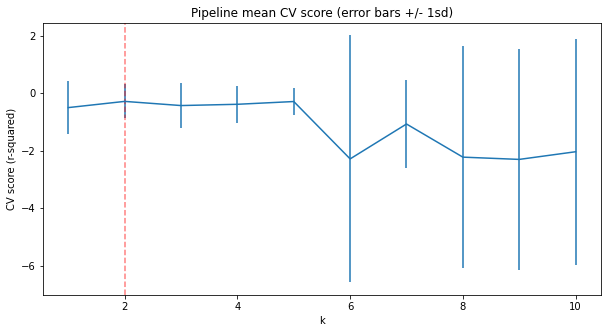

In [108]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [109]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [110]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Force_cat_high         3.556225
Posture_cat_neutral   -4.030713
dtype: float64

In [111]:
#Random Forest Model
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [112]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [113]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-2.36558534,  0.2115982 , -0.25471371,  0.48074381, -0.21180318])

In [114]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.4279520439709792, 1.0065691532005028)

In [115]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [116]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [117]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [118]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'standardscaler': StandardScaler()}

In [119]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-1.89946205,  0.22277261, -0.27316176,  0.45016309, -0.199937  ])

In [120]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.3399250221698703, 0.8242666516679091)

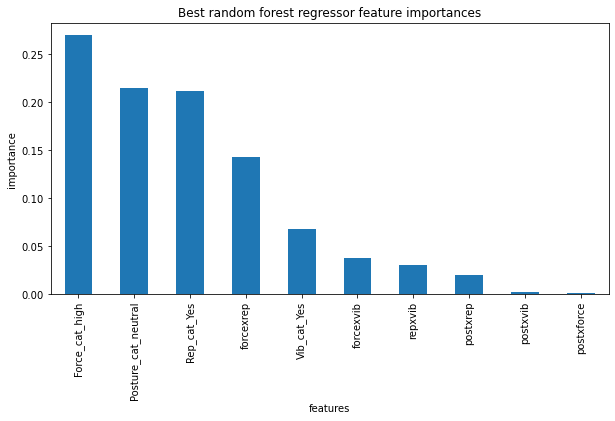

In [121]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [122]:
#Linear regression model performance
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [123]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(11.711148966845562, 2.1497939799459913)

In [124]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

10.562727399944025

In [125]:
mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test), squared=False)

12.025743849595571

In [126]:
#Random forest regression model performance
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [127]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(11.95790854011786, 3.3406964461037543)

In [128]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

14.124790594008386

In [129]:
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test), squared=False)

16.08407651212201

In [130]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


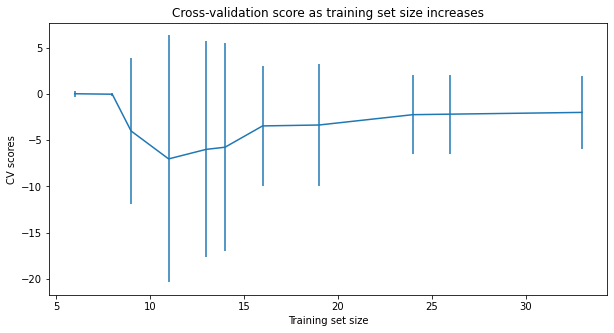

In [131]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

## 4. Modelling

### Tertiary Classification

In [132]:
X_test=X_test[X_train.columns]
X_test.head()

,Posture_cat_neutral,Force_cat_high,Rep_cat_Yes,Vib_cat_Yes,postxforce,postxrep,postxvib,forcexrep,forcexvib,repxvib
46,1,1,1,0,1,1,0,1,0,0
36,0,0,1,0,0,0,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0
54,1,0,0,0,0,0,0,0,0,0
12,0,1,1,1,0,0,0,1,1,1


In [134]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



#roc1 = roc_auc_score(y_test, y_pred1)

#roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

ValueError: Class label 1 not present.

In [ ]:
# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

#roc3 = roc_auc_score(y_test, y_pred3)

#roc3

In [ ]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred3))

In [ ]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [ ]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

In [ ]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

In [ ]:
print(model.best_score_)
print(model.best_params_)

In [ ]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)

In [ ]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Moderate', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

### Binary Classification

In [155]:
X_test=X_test[X_train.columns]
X_test.head()

,Posture_cat_neutral,Rep_cat_Yes,Vib_cat_Yes
46,1,1,0
36,0,1,0
49,0,0,0
54,1,0,0
12,0,1,1


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.56969463 0.33542159 0.09488377]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


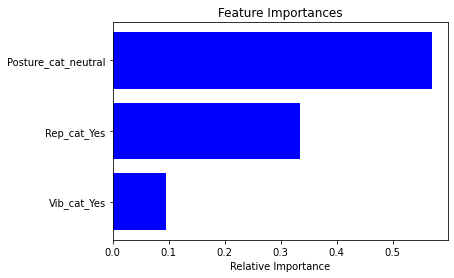

[[1 8]
 [1 8]]


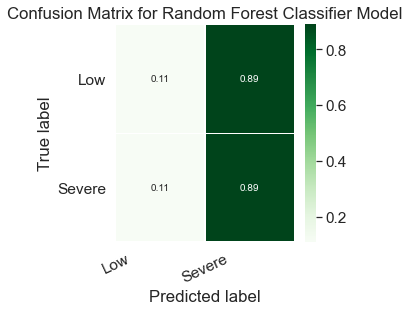

In [156]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

In [157]:
# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

[15:19:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "oob_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:57] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:19:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:57] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:19:57] INFO: /Users/runner/work/

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.5

[[0 9]
 [0 9]]


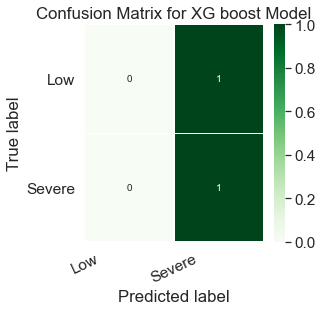

In [158]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [159]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5


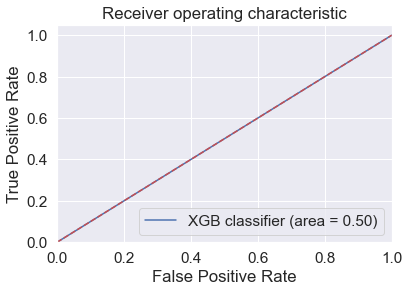

In [160]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [161]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [162]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

In [163]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[15:20:52] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:20:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:52] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:20:52] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:20:52] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:20:52] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc

One or more of the test scores are non-finite: [0.68333333 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333
 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333
 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333
 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333 0.68333333
 0.68333333 0.68333333 0.68333333        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667
 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667
 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667
 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667 0.67666667
 0.67666667 0.67666667 0.67666667        nan        nan        nan
        nan    

In [164]:
print(model.best_score_)
print(model.best_params_)

0.6833333333333333
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 49}


In [165]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)

[15:21:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:21:02] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:21:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:02] INFO: /Users/runner/work/xgboost/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:21:02] INFO: /Users/runner/wor

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.01, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=4, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=50, scoring_fit='roc_auc', subsample=1,
              tree_method='exact', validate_parameters=1, ...)

Test 0.5


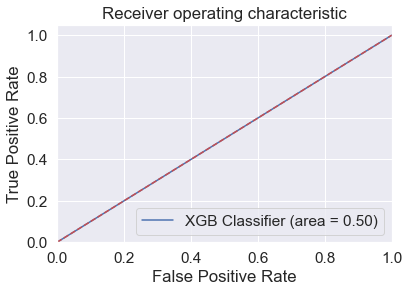

In [166]:
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

print("Test",roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

[[0 9]
 [0 9]]


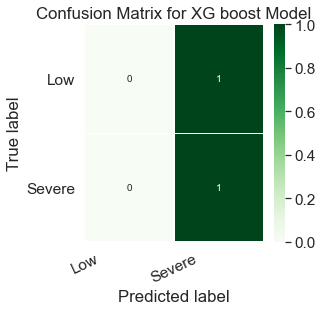

In [167]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low', 'Severe']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


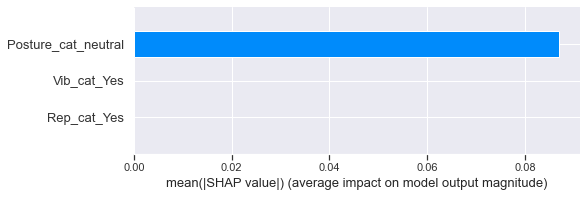

In [169]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

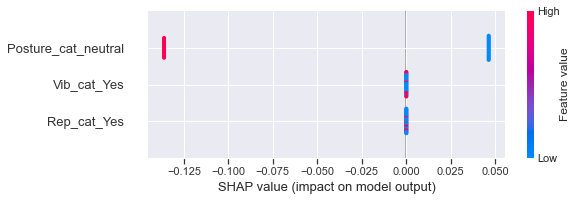

In [170]:
shap.summary_plot(shap_values, X_train)

### Regression

In [135]:
X = df_encoded_fin3.drop(columns='ODI_Score')
y = df_encoded_fin3.ODI_Score

In [136]:
len(X), len(y)

(60, 60)

In [137]:
rf_grid_cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [138]:
cv_results = cross_validate(rf_grid_cv, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [139]:
cv_results['test_score']

array([-15.99890455, -15.3146663 ,  -9.75216534, -13.4221573 ,
       -15.6927413 ])

In [140]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(14.036126958566348, 2.322103171141242)

In [141]:
mean_squared_error(y, rf_grid_cv.predict(X), squared=False)

12.83691523421401